# Haciendo un Clasificador en Segundos

A continuación dejaremos como bonus la forma en la que se puede utilizar un modelo de Red Neuronal pre-entrenado en conjuntos de imágenes naturales, y utilizarlo para clasificar en otro problema. Se llama hacer *fine tuning* para un *downstream task*. 

Utilizaremos un ejemplo de clasificación de Google que se encuentra en https://www.tensorflow.org/tutorials/images/transfer_learning

## Contexto

El Transfer Learning y el Fine Tuning son procedimientos que permiten utilizar una Red Neuronal Pre-Entrenada para aprovechar sus pesos en un nuevo modelo, sin tener que comenzar desde cero. 

En este ejercicio utilizaremos los pesos de MobileNet entrenados con ImageNet para entrenar un clasificador de perros y gatos. Sin embargo, pueden utilizarse otras arquitecturas de modelos y pesos iniciales. 

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

## Descarga de Información

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [3]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


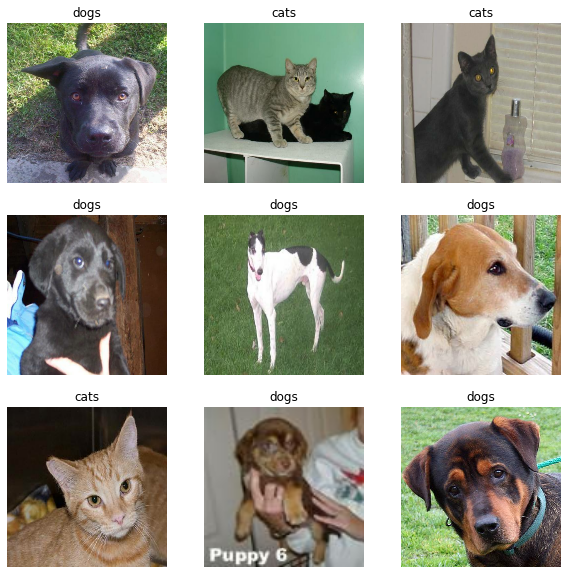

In [4]:
class_names = train_dataset.class_names#

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])   
        plt.axis("off")

A continuación se hace la división del data set de validación en prueba y validación. 

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

# Pre-Procesamiento de Imágenes

El pre-procesamiento de imágenes se debe llevar acabo en dos etapas: 

1. **Data Augmentation** Para generar nuevas imágenes en el conjunto de datos. Es útil cuando hay pocos datos, y ayuda a que el modelo generalice mejor.

2. **Rescaling & Reshaping** Ajustar las imágenes para que cumplan con el tipo de dato que espera el modelo



In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Ejemplos de imágenes

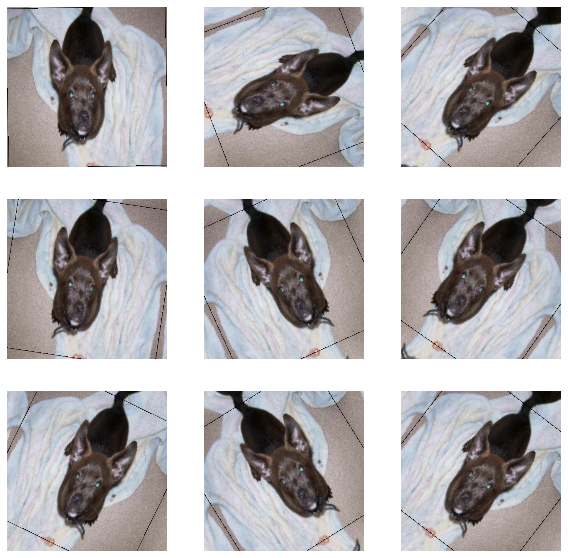

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Selección del Modelo Base

Utilizamos como modelo base MobileNet V2, preentrenado en ImageNet. Este modelo espera que los datos de entrada sean imágenes de tres canales de dimensión (160, 160, 3), y los píxeles vayan en intensidad de -1 a 1. 

Al cargar el modelo dejaremos por fuera la capa de clasificación, de forma que únicamente nos quedamos con MobileNet como extractor de características. 

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
# Instanciamiento del Modelo
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Quita capa de clasificación
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape) # Bloque de características extraídas 5x5x1280

(32, 5, 5, 1280)


Nuestro objetivo es entrenar una capa de clasificación que aproveche los features que aprendió de ImageNet, por lo que no queremos dañar el modelo con nuestros (pocos) datos.

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## ¡Capa de Clasificación!

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Pasamos de 55x1280 a 1x1280
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Definición del Modelo Completo

Aquí buscamos unir nuestros inputs, con el extractor de características `base_model` y una capa de clasificación 

In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) # Podríamos añadir más capas
outputs = tf.keras.layers.Dense(1)(x) # Probabilidad de que sea perro o gato
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [19]:
EPOCHS = 10
loss, accuracy = model.evaluate(validation_dataset) # Desempeño sin entrenar (pesos aleatorios)

26/26 [==============================] - 10s 388ms/step - loss: 0.7145 - accuracy: 0.5718


In [20]:
print("initial loss: {:.2f}".format(loss))
print("initial accuracy: {:.2f}".format(accuracy))

initial loss: 0.71
initial accuracy: 0.57


### Transfer Learning en Acción

A continuación se realiza el entrenamiento del modelo partiendo de los pesos del extractor. Realmente se está entrenando la capa FC que conecta los features a la Dense(1). 

In [21]:
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 44s 705ms/step - loss: 0.6837 - accuracy: 0.6030 - val_loss: 0.4747 - val_accuracy: 0.7339
Epoch 2/10
 8/63 [==>...........................] - ETA: 25s - loss: 0.5358 - accuracy: 0.7109

KeyboardInterrupt: 

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() 

NameError: name 'history' is not defined

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

26/26 [==============================] - 11s 406ms/step - loss: 0.4572 - accuracy: 0.7488
Test accuracy : 0.7487623691558838


# Fine Tuning

Hasta este punto se hizo el entrenamiento de la FC para la clasificación, dejando intacto el extractor de características. Una vez aprendido el clasificador, puede *fine tunearse* el extractor, permitiendo generar características más adecuadas para el conjunto de datos. 

Las capas más altas de la red aprenden características mucho más específicas (y valiosas) que las primeras capas del modelo. ¡Vamos a entrenar esas!

In [ ]:
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

MobileNet cuenta con 155 capas ocultas (nuestro feature extractor). Vamos a Finetunear las últimas 55 capas del modelo, por lo que debemos mantener congeladas las primeras 100. De esta forma las features básicas que aprendió el modelo quedan intactas.

In [ ]:
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)